<a href="https://colab.research.google.com/github/Deanelle/Diabetes_Deep_Learning-/blob/main/Diabetes_Blood_Glucose_Prediction_Deep_Learning_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First to start by loading all of the libraries I may need. 

In [ ]:
import pandas as pd 
from pandas import read_csv
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns 
import plotly.express as px 
from datetime import datetime 
from matplotlib.dates import date2num 
import scipy
import scipy.stats
import statsmodels.api as sm
import sklearn as sk
from sklearn_pandas import DataFrameMapper, cross_val_score
from dateutil.parser import parse as date_parse
import tensorflow as tf
from pathlib import Path
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



I loaded the dataset which is a csv file from my 90 days of blood glucose readings on my Continous Glucose Monitor, the Dexcom G6.  

In [ ]:
df=read_csv('/content/CLARITY_Export_Thompson__Deanelle__2021-11-06_050048.csv',index_col=False)
dataframe = df[['Glucose Value (mg/dL)']]

In [ ]:
df.head()

,Index,Timestamp (YYYY-MM-DDThh:mm:ss),Event Type,Event Subtype,Patient Info,Device Info,Source Device ID,Glucose Value (mg/dL),Insulin Value (u),Carb Value (grams),Duration (hh:mm:ss),Glucose Rate of Change (mg/dL/min),Transmitter Time (Long Integer),Transmitter ID
0,1,NaN,FirstName,NaN,Deanelle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,LastName,NaN,Thompson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,Device,NaN,NaN,Dexcom G6 Mobile App,iPhone G6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,Alert,Fall,NaN,NaN,iPhone G6,NaN,NaN,NaN,NaN,3.0,NaN,NaN
4,5,NaN,Alert,High,NaN,NaN,iPhone G6,190,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.tail()

,Index,Timestamp (YYYY-MM-DDThh:mm:ss),Event Type,Event Subtype,Patient Info,Device Info,Source Device ID,Glucose Value (mg/dL),Insulin Value (u),Carb Value (grams),Duration (hh:mm:ss),Glucose Rate of Change (mg/dL/min),Transmitter Time (Long Integer),Transmitter ID
11176,11177,2021-11-04T12:34:56,EGV,NaN,NaN,NaN,iPhone G6,98,NaN,NaN,NaN,NaN,8655674.0,8P78GM
11177,11178,2021-11-04T12:39:55,EGV,NaN,NaN,NaN,iPhone G6,102,NaN,NaN,NaN,NaN,8655974.0,8P78GM
11178,11179,2021-11-04T12:44:55,EGV,NaN,NaN,NaN,iPhone G6,102,NaN,NaN,NaN,NaN,8656274.0,8P78GM
11179,11180,2021-11-04T12:49:55,EGV,NaN,NaN,NaN,iPhone G6,100,NaN,NaN,NaN,NaN,8656574.0,8P78GM
11180,11181,2021-11-04T12:54:55,EGV,NaN,NaN,NaN,iPhone G6,99,NaN,NaN,NaN,NaN,8656874.0,8P78GM


After checking the first and last few rows in the dataset, there are a lot of missing values here that we will need to clean. 

In [ ]:
df.isnull()

,Index,Timestamp (YYYY-MM-DDThh:mm:ss),Event Type,Event Subtype,Patient Info,Device Info,Source Device ID,Glucose Value (mg/dL),Insulin Value (u),Carb Value (grams),Duration (hh:mm:ss),Glucose Rate of Change (mg/dL/min),Transmitter Time (Long Integer),Transmitter ID
0,False,True,False,True,False,True,True,True,True,True,True,True,True,True
1,False,True,False,True,False,True,True,True,True,True,True,True,True,True
2,False,True,False,True,True,False,False,True,True,True,True,True,True,True
3,False,True,False,False,True,True,False,True,True,True,True,False,True,True
4,False,True,False,False,True,True,False,False,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11176,False,False,False,True,True,True,False,False,True,True,True,True,False,False
11177,False,False,False,True,True,True,False,False,True,True,True,True,False,False
11178,False,False,False,True,True,True,False,False,True,True,True,True,False,False
11179,False,False,False,True,True,True,False,False,True,True,True,True,False,False


In [ ]:
df.isnull().sum()

Index                                     0
Timestamp (YYYY-MM-DDThh:mm:ss)          10
Event Type                                0
Event Subtype                         11106
Patient Info                          11179
Device Info                           11180
Source Device ID                          2
Glucose Value (mg/dL)                     6
Insulin Value (u)                     11181
Carb Value (grams)                    11181
Duration (hh:mm:ss)                   11180
Glucose Rate of Change (mg/dL/min)    11179
Transmitter Time (Long Integer)          10
Transmitter ID                           10
dtype: int64

The amount of null values in the data. 

Because I am only interested in the timestamps and the Glucose value of the data I am going to drop all other columns. 

In [ ]:
BG=df[['Timestamp (YYYY-MM-DDThh:mm:ss)','Glucose Value (mg/dL)']]
BG=BG.drop([1,2,3,4,5,6,7,8,9,19,11,12])

In [ ]:
BG.reset_index(drop=True,inplace=True)
BG['Timestamp (YYYY-MM-DDThh:mm:ss)']=pd.to_datetime(BG['Timestamp (YYYY-MM-DDThh:mm:ss)'])

In [ ]:
BG=BG.rename(columns={'Timestamp (YYYY-MM-DDThh:mm:ss)':'Timestamp'})

In [ ]:
BG

,Timestamp,Glucose Value (mg/dL)
0,NaT,NaN
1,2021-09-19 13:15:51,173
2,2021-09-19 13:30:51,142
3,2021-09-19 13:35:50,129
4,2021-09-19 13:40:50,124
...,...,...
11164,2021-11-04 12:34:56,98
11165,2021-11-04 12:39:55,102
11166,2021-11-04 12:44:55,102
11167,2021-11-04 12:49:55,100


There is a NAT value here that I will clean. 

In [ ]:
# dropping passed values
BG.drop([0], inplace = True)

To get rid of the NAT value, I dropped row 0. 

In [ ]:
BG

,Timestamp,Glucose Value (mg/dL)
1,2021-09-19 13:15:51,173
2,2021-09-19 13:30:51,142
3,2021-09-19 13:35:50,129
4,2021-09-19 13:40:50,124
5,2021-09-19 13:45:50,122
...,...,...
11164,2021-11-04 12:34:56,98
11165,2021-11-04 12:39:55,102
11166,2021-11-04 12:44:55,102
11167,2021-11-04 12:49:55,100


In [ ]:
BG.isnull().sum()

Timestamp                0
Glucose Value (mg/dL)    0
dtype: int64

There are no missing values now. 

In [ ]:
BG[pd.notnull(BG['Timestamp'])]

,Timestamp,Glucose Value (mg/dL)
1,2021-09-19 13:15:51,173
2,2021-09-19 13:30:51,142
3,2021-09-19 13:35:50,129
4,2021-09-19 13:40:50,124
5,2021-09-19 13:45:50,122
...,...,...
11164,2021-11-04 12:34:56,98
11165,2021-11-04 12:39:55,102
11166,2021-11-04 12:44:55,102
11167,2021-11-04 12:49:55,100


In [ ]:
BG.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,Timestamp,Glucose Value (mg/dL)
count,11168,11168
unique,11168,296
top,2021-09-28 08:45:40,131
freq,1,111
first,2021-09-19 13:15:51,NaN
last,2021-11-04 12:54:55,NaN


I was checking for the desriptive statistics here but got this instead.This will be handled later. 

In [ ]:
BG.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11168 entries, 1 to 11168
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Timestamp              11168 non-null  datetime64[ns]
 1   Glucose Value (mg/dL)  11168 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 261.8+ KB


The Glucose Value here being an object type. We will revist this later. 

There are 11168 observations in the data and two columns. 

In [ ]:
BG['Glucose Value (mg/dL)']

1        173
2        142
3        129
4        124
5        122
        ... 
11164     98
11165    102
11166    102
11167    100
11168     99
Name: Glucose Value (mg/dL), Length: 11168, dtype: object

In [ ]:
BG.loc[7603]

Timestamp                2021-10-17 04:55:19
Glucose Value (mg/dL)                     78
Name: 7603, dtype: object

Just experimenting with the .loc function to check specific data points. 

In [ ]:
category_counts=BG['Glucose Value (mg/dL)'].value_counts()

category_counts.head(10)

131    111
133    111
124    110
123    110
130    109
132    108
145    107
129    105
119    105
125    104
Name: Glucose Value (mg/dL), dtype: int64

In [ ]:
category_counts=BG['Timestamp'].value_counts()

category_counts.head(10)

2021-09-28 08:45:40    1
2021-10-30 11:35:03    1
2021-09-19 20:35:50    1
2021-09-24 15:25:44    1
2021-10-30 07:45:01    1
2021-09-23 13:45:47    1
2021-10-04 01:25:33    1
2021-09-20 10:00:49    1
2021-10-27 17:30:06    1
2021-10-13 15:45:22    1
Name: Timestamp, dtype: int64

In [ ]:
dataframe['Glucose Value (mg/dL)'] = pd.to_numeric(dataframe['Glucose Value (mg/dL)'], errors='coerce')
dataframe = dataframe[dataframe['Glucose Value (mg/dL)'].notna()]
dataframe = dataframe[['Glucose Value (mg/dL)']]
#dataframe = clean_dataset(dataframe)

dataframe.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Glucose Value (mg/dL)
4,190.0
5,85.0
8,55.0
9,55.0
10,173.0


I used the pd.to_numeric function to convert the Glucose value into a numeric type which will make running my models later easier. 

**Data Exploration**

Text(0.5, 1.0, 'Glucose')

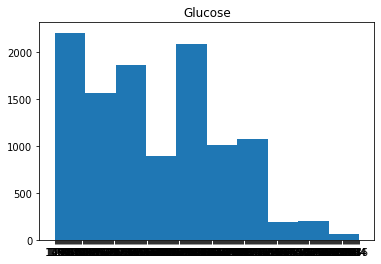

In [ ]:
plt.hist(BG['Glucose Value (mg/dL)'])
plt.title('Glucose')

Text(0.5, 1.0, 'Time')

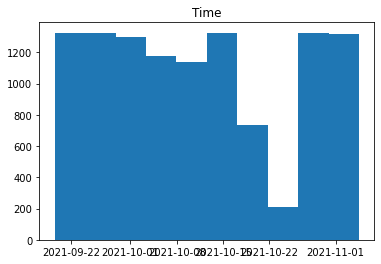

In [ ]:
plt.hist(BG['Timestamp'])
plt.title('Time')

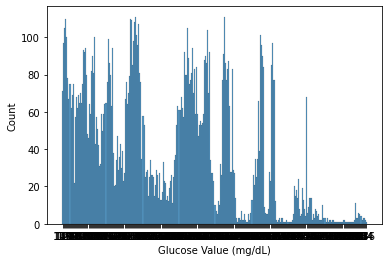

In [ ]:
ax = sns.histplot(BG['Glucose Value (mg/dL)'])

In [ ]:
BG['Day'] = BG['Timestamp'].dt.day_name()

fig = px.box(BG, x="Day", y="Glucose Value (mg/dL)",
             points="all", color='Day')
fig.show()

This graph is split based on day of the week. It tells us the lowest and highest glucose values over the 90 day period on each day. For example, if you were to look at Friday, the lowest value is 53 and the highest value is 267. Whatever was done on that day needs to continue. My worse range for glucose levels was Saturday. The lowest glucose was 42 and the highest was 373.  This possibly could be explained by my work schedule as on most Saturday's I do not work and have the tendency to stay home which could mean more snacking, lounging around and getting off of my treatment plan. 

In [ ]:
ranges= [0,70,180,350]

In [ ]:
BG['Glucose Value (mg/dL)'] = pd.to_numeric(BG['Glucose Value (mg/dL)'], errors='coerce')

In [ ]:
ranges= [0,70,180,350]
BG['ranges']= pd.cut(BG['Glucose Value (mg/dL)'] , bins = ranges)
result = (BG.groupby([pd.Grouper(key="Timestamp",freq="D"),'ranges'])['ranges'].count()
          .unstack(0).T.fillna(0))

summed_results = result.sum()

In [ ]:

less70 = 'Time < 70:'
in_range = 'Time in range:'
greater180 = 'Time > 180:'
var_percent = '%'

print(f'{less70:15} {str(round(summed_results.iloc[0]/summed_results.sum()*100,2))}{var_percent}')
print(f'{in_range:15} {str(round(summed_results.iloc[1]/summed_results.sum()*100,2))}{var_percent}')
print(f'{greater180:15} {str(round(summed_results.iloc[2]/summed_results.sum()*100,2))}{var_percent}')

Time < 70:      3.53%
Time in range:  75.68%
Time > 180:     20.79%


The percentage of time gives an indication of general behavior of CGM variations. These results were calculated by taking a simple percentage of the total for each discrete time period. 

Text(0, 0.5, 'Glucose Value (mg/dL)')

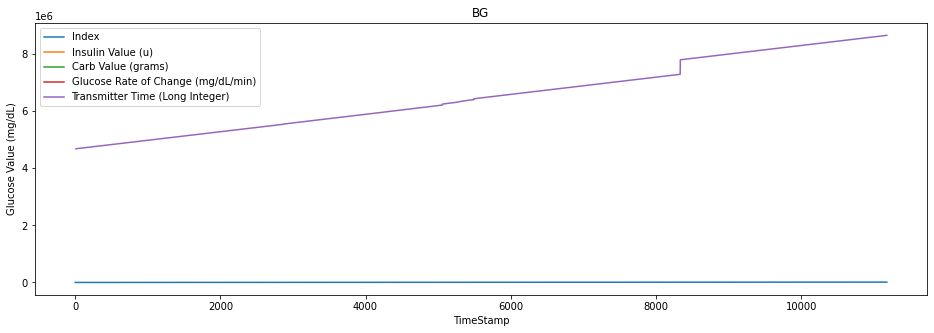

In [ ]:
ax = df.plot(figsize=(16,5), title='BG')
ax.set_xlabel("TimeStamp")
ax.set_ylabel("Glucose Value (mg/dL)")

In [ ]:
BG['BG Rate of Change'] = BG['Glucose Value (mg/dL)'].diff()/5

bg_roc_std = BG['BG Rate of Change'].std()
bg_roc_mean = BG['BG Rate of Change'].mean()

Text(0.5, 0, 'BG Rate of Change (mg/dL/minute)')

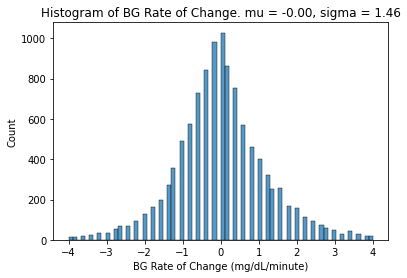

In [ ]:
sns.histplot(data=BG, x='BG Rate of Change',binrange=(-4,4))
plt.title(f'Histogram of BG Rate of Change. mu = {bg_roc_mean:.2f}, sigma = {bg_roc_std:.2f}')
plt.xlabel('BG Rate of Change (mg/dL/minute)')

I measured the standard deviation of the blood glucose data to see the amount of variability in it;whether or not the data points are clustered together or spread out. The SD value here is 1.46 which means that there is some spread in the data but not a lot. 

A higher standard deviation of Blood Glucose(BG) indicates increased BG variability and thus worse control. 

In [ ]:
BG['Lag (mg/dL)'] = BG['Glucose Value (mg/dL)'].shift(1)

Poincare Plot- another visualization to measure glucose control. 

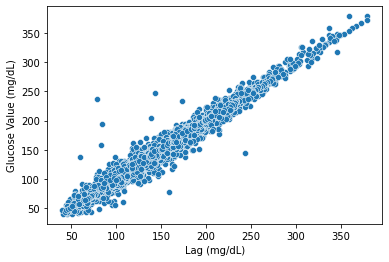

In [ ]:
sns.scatterplot(x='Lag (mg/dL)',y='Glucose Value (mg/dL)',data=BG)

Glancing at the plot, you can see that the points appear to be clustered together which indicates patient stability. If the graph was more scatted like some of the points you see in the graph, this indicates patient irregularity, which means pooer glucose control and rapid glucose fluctuatons. 

Control Variability Grid Analysis- Another tool for visualizing overall glycemic control. 

In [ ]:
min_max_day= BG.groupby(pd.Grouper(key='Timestamp', freq='1D')).agg({'Glucose Value (mg/dL)':[np.min, np.max]})

In [ ]:
img = plt.imread('CVGA.png')

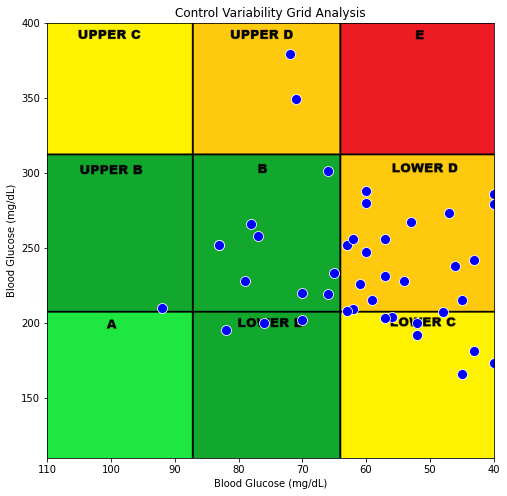

In [ ]:
fig, ax = plt.subplots(figsize = (8,8))
sns.scatterplot(data=min_max_day,x=min_max_day['Glucose Value (mg/dL)']['amin'],
                y=min_max_day['Glucose Value (mg/dL)']['amax'], zorder=1,
                color='blue', s=100)
ax.imshow(img, extent=[110, 40, 110, 400], aspect='auto')
plt.title('Control Variability Grid Analysis')
plt.xlabel('Blood Glucose (mg/dL)')
plt.ylabel('Blood Glucose (mg/dL)');

Each point represents one day in this 90 day period. 
The x-coordinate for each point is the minimum BG in that 24 hour period and the y-coordinate is ghe maximum BG value in the same 24 hour period.
I calculated these values by creating a new DF aggregated by day and using Numpy's min and max aggreagation functions. 
An ideal day would fall in the green areas of the graph, with a perfect day being in the "A" subsection. 
Days in the "A" subsection would have lower BG numbers between 90 and 110, with higher BG numbers less than 180. 

In [ ]:
min_max_day=BG.groupby(pd.Grouper(key='Timestamp',freq='1D')).agg({'Glucose Value (mg/dL)':[np.min,np.max]})
min_max_day

Glucose Value (mg/dL)       
                            amin   amax
Timestamp                              
2021-09-19                  62.0  209.0
2021-09-20                  78.0  266.0
2021-09-21                  66.0  301.0
2021-09-22                  71.0  349.0
2021-09-23                  60.0  247.0
2021-09-24                  53.0  267.0
2021-09-25                  76.0  200.0
2021-09-26                  70.0  202.0
2021-09-27                  63.0  208.0
2021-09-28                  43.0  181.0
2021-09-29                  40.0  279.0
2021-09-30                  77.0  258.0
2021-10-01                  63.0  252.0
2021-10-02                  72.0  379.0
2021-10-03                  59.0  215.0
2021-10-04                  65.0  233.0
2021-10-05                  52.0  192.0
2021-10-06                  60.0  288.0
2021-10-07                  62.0  256.0
2021-10-08                  56.0  204.0
2021-10-09                  40.0  173.0
2021-10-10                  48.0  207.0
2021-10-11                  60.0  280.0
2021-10-12                  70.0  220.0
2021-10-13                  66.0  219.0
2021-10-14                  79.0  228.0
2021-10-15                  57.0  231.0
2021-10-16                  54.0  228.0
2021-10-17                  46.0  238.0
2021-10-18                  40.0  286.0
2021-10-19                  45.0  215.0
2021-10-20                   NaN    NaN
2021-10-21                   NaN    NaN
2021-10-22                   NaN    NaN
2021-10-23                   NaN    NaN
2021-10-24                   NaN    NaN
2021-10-25                  45.0  166.0
2021-10-26                  52.0  200.0
2021-10-27                  47.0  273.0
2021-10-28                  43.0  242.0
2021-10-29                  61.0  226.0
2021-10-30                  92.0  210.0
2021-10-31                  83.0  252.0
2021-11-01                  82.0  195.0
2021-11-02                  57.0  256.0
2021-11-03                  57.0  203.0
2021-11-04                  83.0  252.0

In [ ]:
BG.describe()

,Glucose Value (mg/dL),BG Rate of Change,Lag (mg/dL)
count,11100.000000,11085.000000,11099.000000
mean,144.492342,-0.003049,144.496441
std,47.610396,1.461566,47.610583
min,40.000000,-19.800000,40.000000
25%,110.000000,-0.600000,110.000000
50%,140.000000,0.000000,140.000000
75%,173.000000,0.600000,173.000000
max,379.000000,31.600000,379.000000


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

LSTM

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
# fix random seed for reproducibility
np.random.seed(7)


In [ ]:
dataset = dataframe.values
dataset = dataset.astype('float32')

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset=scaler.fit_transform(dataset)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(BG),:]
print(len(train), len(test))

7441 3666


In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
7439/7439 - 12s - loss: 0.0042 - 12s/epoch - 2ms/step
Epoch 2/100
7439/7439 - 10s - loss: 5.8225e-04 - 10s/epoch - 1ms/step
Epoch 3/100
7439/7439 - 10s - loss: 5.8246e-04 - 10s/epoch - 1ms/step
Epoch 4/100
7439/7439 - 10s - loss: 5.8594e-04 - 10s/epoch - 1ms/step
Epoch 5/100
7439/7439 - 10s - loss: 5.7764e-04 - 10s/epoch - 1ms/step
Epoch 6/100
7439/7439 - 10s - loss: 5.8522e-04 - 10s/epoch - 1ms/step
Epoch 7/100
7439/7439 - 10s - loss: 5.8109e-04 - 10s/epoch - 1ms/step
Epoch 8/100
7439/7439 - 10s - loss: 5.8148e-04 - 10s/epoch - 1ms/step
Epoch 9/100
7439/7439 - 10s - loss: 5.8273e-04 - 10s/epoch - 1ms/step
Epoch 10/100
7439/7439 - 10s - loss: 5.8222e-04 - 10s/epoch - 1ms/step
Epoch 11/100
7439/7439 - 10s - loss: 5.8023e-04 - 10s/epoch - 1ms/step
Epoch 12/100
7439/7439 - 10s - loss: 5.8023e-04 - 10s/epoch - 1ms/step
Epoch 13/100
7439/7439 - 10s - loss: 5.7950e-04 - 10s/epoch - 1ms/step
Epoch 14/100
7439/7439 - 10s - loss: 5.8118e-04 - 10s/epoch - 1ms/step
Epoch 15/100
7439/7

In [ ]:
import math

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))



Train Score: 8.02 RMSE
Test Score: 7.04 RMSE


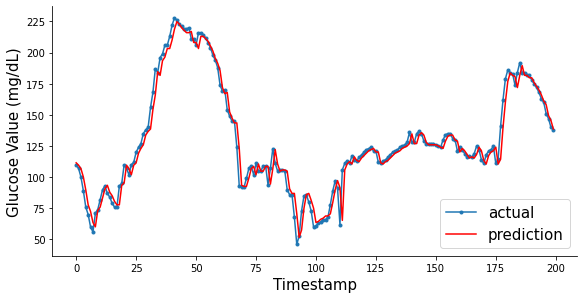

In [ ]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, testY[0][:200], marker='.', label="actual")
plt.plot(aa, testPredict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Glucose Value (mg/dL)', size=15)
plt.xlabel('Timestamp', size=15)
plt.legend(fontsize=15) 
plt.show();

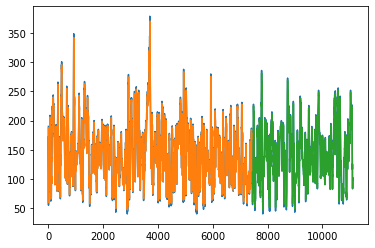

In [ ]:

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
BG.mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



Glucose Value (mg/dL)    144.492342
BG Rate of Change         -0.003049
Lag (mg/dL)              144.496441
dtype: float64

Stacked LSTM 

In [ ]:
from numpy import array
# define model where LSTM is also output layer
model = Sequential()
model.add(LSTM(1, return_sequences=True, input_shape=(3,look_back)))
model.compile(optimizer='adam', loss='mse')
# input time steps
data = array([0.1, 0.2, 0.3]).reshape((1,3,1))
# make and show prediction
print(model.predict(data))

[[[-0.00381625]
  [-0.01067659]
  [-0.01992403]]]


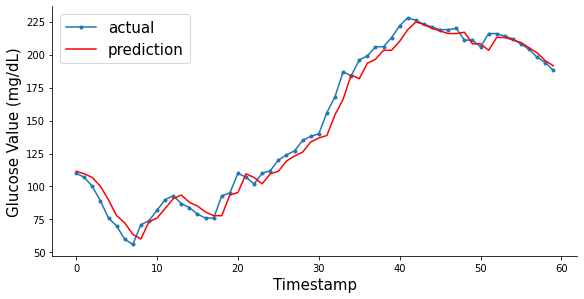

In [ ]:
aa=[x for x in range(60)]
plt.figure(figsize=(8,4))
plt.plot(aa, testY[0][:60], marker='.', label="actual")
plt.plot(aa, testPredict[:,0][:60], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Glucose Value (mg/dL)', size=15)
plt.xlabel('Timestamp', size=15)
plt.legend(fontsize=15) 
plt.show();

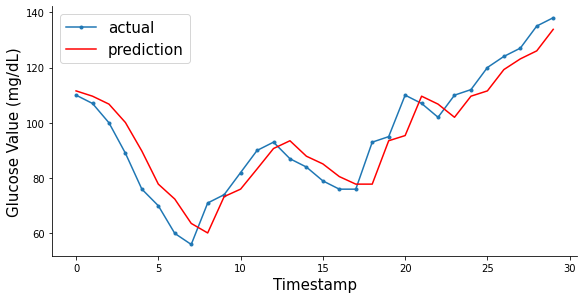

In [ ]:
aa=[x for x in range(30)]
plt.figure(figsize=(8,4))
plt.plot(aa, testY[0][:30], marker='.', label="actual")
plt.plot(aa, testPredict[:,0][:30], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Glucose Value (mg/dL)', size=15)
plt.xlabel('Timestamp', size=15)
plt.legend(fontsize=15) 
plt.show();

In [ ]:
# define model where LSTM is also output layer
model = Sequential()
model.add(LSTM(1, return_sequences=True, input_shape=(3,look_back)))
model.add(LSTM(1, return_sequences=True))
model.compile(optimizer='adam', loss='mse')
# input time steps
data = array([0.1, 0.2, 0.3]).reshape((1,3,1))
# make and show prediction
print(model.predict(data))

[[[-0.00018008]
  [-0.0006297 ]
  [-0.0013884 ]]]


CNN

In [ ]:
from keras.layers.convolutional import Conv1D

In [ ]:

# multivariate multi-headed 1d cnn example
from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# one time series per head
n_features = 1
# separate input data
X1 = X[:, :, 0].reshape(X.shape[0], X.shape[1], n_features)
X2 = X[:, :, 1].reshape(X.shape[0], X.shape[1], n_features)
# first input model
visible1 = Input(shape=(n_steps, n_features))
cnn1 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible1)
cnn1 = MaxPooling1D(pool_size=2)(cnn1)
cnn1 = Flatten()(cnn1)
# second input model
visible2 = Input(shape=(n_steps, n_features))
cnn2 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible2)
cnn2 = MaxPooling1D(pool_size=2)(cnn2)
cnn2 = Flatten()(cnn2)
# merge input models
merge = concatenate([cnn1, cnn2])
dense = Dense(50, activation='relu')(merge)
output = Dense(1)(dense)
model = Model(inputs=[visible1, visible2], outputs=output)
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit([X1, X2], y, epochs=1000, verbose=0)
# demonstrate prediction
x_input = array([[80, 85], [90, 95], [100, 105]])
x1 = x_input[:, 0].reshape((1, n_steps, n_features))
x2 = x_input[:, 1].reshape((1, n_steps, n_features))
yhat = model.predict([x1, x2], verbose=0)
print(yhat)

[[205.91057]]


In [ ]:

# univariate cnn example
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=1000, verbose=0)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[101.55627]]


In [ ]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
7437/7437 - 13s - loss: 0.0036 - 13s/epoch - 2ms/step
Epoch 2/100
7437/7437 - 11s - loss: 7.3525e-04 - 11s/epoch - 1ms/step
Epoch 3/100
7437/7437 - 10s - loss: 5.7039e-04 - 10s/epoch - 1ms/step
Epoch 4/100
7437/7437 - 10s - loss: 5.5231e-04 - 10s/epoch - 1ms/step
Epoch 5/100
7437/7437 - 11s - loss: 5.4334e-04 - 11s/epoch - 1ms/step
Epoch 6/100
7437/7437 - 11s - loss: 5.4320e-04 - 11s/epoch - 1ms/step
Epoch 7/100
7437/7437 - 11s - loss: 5.3590e-04 - 11s/epoch - 1ms/step
Epoch 8/100
7437/7437 - 11s - loss: 5.3383e-04 - 11s/epoch - 1ms/step
Epoch 9/100
7437/7437 - 11s - loss: 5.3203e-04 - 11s/epoch - 1ms/step
Epoch 10/100
7437/7437 - 11s - loss: 5.3091e-04 - 11s/epoch - 1ms/step
Epoch 11/100
7437/7437 - 11s - loss: 5.2648e-04 - 11s/epoch - 1ms/step
Epoch 12/100
7437/7437 - 11s - loss: 5.2873e-04 - 11s/epoch - 1ms/step
Epoch 13/100
7437/7437 - 11s - loss: 5.3098e-04 - 11s/epoch - 1ms/step
Epoch 14/100
7437/7437 - 11s - loss: 5.2511e-04 - 11s/epoch - 1ms/step
Epoch 15/100
7437/7

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 7.45 RMSE
Test Score: 6.52 RMSE


In [ ]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()

7437/7437 - 14s - loss: 0.0030 - 14s/epoch - 2ms/step
7437/7437 - 13s - loss: 0.0011 - 13s/epoch - 2ms/step
7437/7437 - 13s - loss: 6.2750e-04 - 13s/epoch - 2ms/step
7437/7437 - 13s - loss: 6.4348e-04 - 13s/epoch - 2ms/step
7437/7437 - 13s - loss: 6.2784e-04 - 13s/epoch - 2ms/step
7437/7437 - 13s - loss: 5.9888e-04 - 13s/epoch - 2ms/step
7437/7437 - 13s - loss: 5.8526e-04 - 13s/epoch - 2ms/step
7437/7437 - 13s - loss: 5.7843e-04 - 13s/epoch - 2ms/step
7437/7437 - 12s - loss: 5.7295e-04 - 12s/epoch - 2ms/step
7437/7437 - 13s - loss: 5.6749e-04 - 13s/epoch - 2ms/step
7437/7437 - 13s - loss: 5.6217e-04 - 13s/epoch - 2ms/step
7437/7437 - 13s - loss: 5.5720e-04 - 13s/epoch - 2ms/step
7437/7437 - 13s - loss: 5.5270e-04 - 13s/epoch - 2ms/step
7437/7437 - 13s - loss: 5.4873e-04 - 13s/epoch - 2ms/step
7437/7437 - 13s - loss: 5.4527e-04 - 13s/epoch - 2ms/step
7437/7437 - 13s - loss: 5.4228e-04 - 13s/epoch - 2ms/step
7437/7437 - 13s - loss: 5.3971e-04 - 13s/epoch - 2ms/step
7437/7437 - 13s - loss

In [ ]:
# make predictions
model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

In [ ]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 50911.60 RMSE
Test Score: 50570.29 RMSE


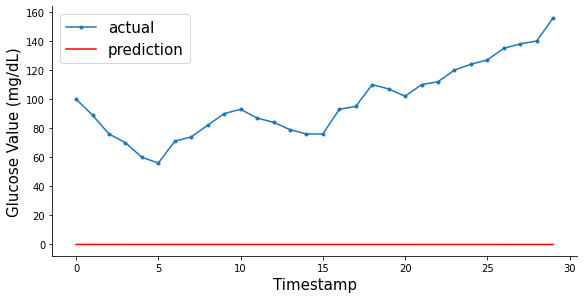

In [ ]:
aa=[x for x in range(30)]
plt.figure(figsize=(8,4))
plt.plot(aa, testY[0][:30], marker='.', label="actual")
plt.plot(aa, testPredict[:,0][:30], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Glucose Value (mg/dL)', size=15)
plt.xlabel('Timestamp', size=15)
plt.legend(fontsize=15) 
plt.show();